In [1]:
import os
from pprint import pprint
from pathlib import Path
from copy import deepcopy

import numpy as np
from scipy.constants import pi
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import rcParams
rcParams["font.size"] = 18

from quvac.postprocess import integrate_spherical
from quvac.plotting import plot_mollweide
from quvac.utils import write_yaml, read_yaml

SCRIPT_PATH = '../src/quvac/simulation.py'
PARALLEL_PATH = '../src/quvac/simulation_parallel.py'
GRIDSCAN_PATH = '../src/quvac/cluster/gridscan.py'
OPTIMIZATION_PATH = '../src/quvac/cluster/optimization.py'

path = "../data/tutorials/tutorial_4"
Path(path).mkdir(parents=True, exist_ok=True)

## Light-by-light scenario

In what follows, we would demonstrate the usage of parallel simulations, gridscan and optimization. All of these examples would be based on two counter-propagating gaussian setup, parameters of which we define here.

In [2]:
lam = 800e-9
w0 = 2 * lam
tau = 25e-15

# all parameters in SI units
field_1_params = {
    "field_type": "paraxial_gaussian_maxwell",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": 0,
    "phi": 0,
    "beta": 0,
    "phase0": 0,
    "lam": lam,
    "w0": w0,
    "tau": tau,
    "W": 25,
    "order": 0,
}

# add counter-propagating field
# (it has the same parameters apart from propagation direction and polarization)
field_2_params = deepcopy(field_1_params)
field_2_params["theta"] = 180
field_2_params["beta"] = 45

# combine
fields_params = {
    "field_1": field_1_params,
    "field_2": field_2_params,
}

# grid parameters
grid_params = {
    'mode': 'dynamic',
    'collision_geometry': 'z',
    'transverse_factor': 20,
    'longitudinal_factor': 8,
    'time_factor': 4,
    'spatial_resolution': 1,
    'time_resolution': 2,
}

ini_data = {
    'mode': 'simulation_postprocess',
    'fields': fields_params,
    'grid': grid_params,
    'integrator': {
        'type': 'vacuum_emission',
    },
}

## Parallel simulations

quvac can run a simulation in parallel by splitting the discretized time integral between different jobs and then collecting results together. A separate script and command is responsible for such computation. To control the parameters of parallelization (number of jobs, parameters of each job), a separate section in `ini.yml` is required.

Usually such parallelization makes sense only on cluster enviroments.

We would calculate the same counter-propagating setup.

The parallel calculation is launched on the slurm cluster (this is controlled by `cluster`: 'local' or 'slurm'). Provide necessary sbatch parameters (they are similar to stardard sbatch scripts) which could be looked up as possible keyword arguments from [submitit](https://github.com/facebookincubator/submitit).

In [4]:
# cluster parameters <---- NEW
cluster_params = {
    'n_jobs': 4,
    'cluster': 'slurm',
    'sbatch_params': {
        'cpus_per_task': 8,
        'slurm_mem': '1GB',
        'timeout_min': 60,
    },
}

ini_data_local = deepcopy(ini_data)
ini_data_local['cluster_params'] = cluster_params

folder_seq = "sequential"
folder_par = "parallel"    

In [5]:
def launch_simulation(ini_data_local, folder, n_jobs):
    ini_data_local['cluster_params']['n_jobs'] = n_jobs
    
    path_local = os.path.join(path, folder)
    Path(path_local).mkdir(parents=True, exist_ok=True)
    ini_file = os.path.join(path_local, 'ini.yml')
    write_yaml(ini_file, ini_data_local)

    status = os.system(f"{PARALLEL_PATH} --input {ini_file}")

If the cost of field initialization is neglidgeable compared to the vacuum emission amplitude calculation then the speedup is typically around number of jobs. One should take into account that disk memory usage also grows with the number of jobs.

In [6]:
launch_simulation(ini_data_local, folder_seq, n_jobs=1)


Timings:
Run jobs:                     1 min 6.87 s
Postprocess:                        0.05 s
----------------------------------------------------
Total:                        1 min 6.93 s

Memory (max usage):
Running jobs:                    146.53 MB
Total:                           156.26 MB

Simulation finished!


In [7]:
launch_simulation(ini_data_local, folder_par, n_jobs=4)


Timings:
Run jobs:                          25.85 s
Postprocess:                        0.08 s
----------------------------------------------------
Total:                             25.93 s

Memory (max usage):
Running jobs:                    146.63 MB
Total:                           156.82 MB

Simulation finished!


## Gridscan

For the gridscan script we need to specify the parameters for which the grid would be created (as well as grid properties).
Then the script creates grids for requested parameters, writes `ini.yml` file for each simulation and does the job submission with `submitit`. 

Here we consider the same two gaussian counter-propagating setup and make a gridscan over polarization orientation of one of the beams ($\beta$).

In [9]:
def launch_gridscan(ini_data_local, folder):
    path_local = os.path.join(path, folder)
    Path(path_local).mkdir(parents=True, exist_ok=True)
    ini_file = os.path.join(path_local, 'ini.yml')
    write_yaml(ini_file, ini_data_local)

    status = os.system(f"{GRIDSCAN_PATH} --input {ini_file}")

In [10]:
# gridscan parameters <---- NEW
variables_data = {
    'create_grids': True,
    'fields': {
        'field_2': {
            'beta': [0, 90, 10]
        }
    },
    'cluster': {
        'cluster': 'slurm',
        'max_parallel_jobs': 5,
        'sbatch_params': {
            'slurm_partition': 'hij-gpu',
            'cpus_per_task': 4,
            'slurm_mem': '1GB',
            'timeout_min': 60,   
        },
    },
}

ini_data_local = deepcopy(ini_data)
ini_data_local["variables"] = variables_data

folder = "gridscan"

In [11]:
launch_gridscan(ini_data_local, folder)

Submitting jobs...
Jobs submitted, waiting for results...
Grid scan is finished!


### Plot results

In [14]:
beta_start, beta_end, n_pts = variables_data["fields"]["field_2"]["beta"]
betas = np.linspace(beta_start, beta_end, n_pts, dtype=int)
N_totals = []

for beta in betas:
    path_local = os.path.join(path, folder, f"#field_2:beta_{beta}")
    data = np.load(os.path.join(path_local, "spectra_total.npz"))
    N_totals.append(data["N_total"])

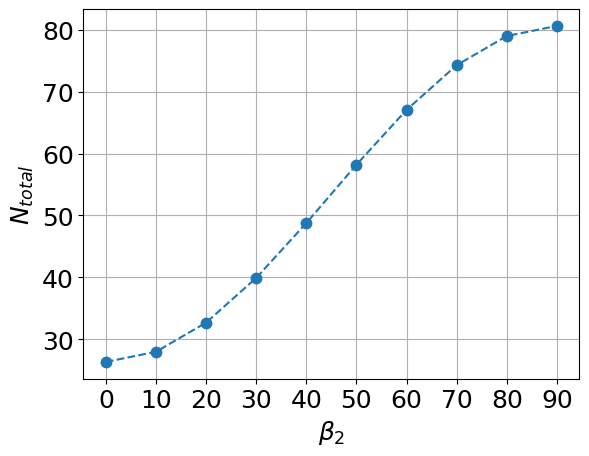

In [19]:
plt.figure()
plt.plot(betas, N_totals, ".--", ms=15)
plt.grid()
plt.xticks(betas)
plt.xlabel("$\\beta_2$")
plt.ylabel("$N_{total}$")
plt.show()

The first beam's polarization is aligned along $x$ ($\beta_1 = 0^{\circ}$), $\beta_2$ is the polarization of the second beam. We know that the maximal total signal is achieved for the polarization difference $\Delta \beta = 90^{\circ}$ which agrees with the plot above.

## Optimization

Optimization script requires its own set of parameters defining both optimization procedure parameters and sbatch specifications for each job (similar to gridscan). The Bayesian optimization is performed with `Ax` library and job submission is taken care by `submitit`.

Here we would optimize the polarization alignment of the 2nd beam ($\beta_2$) to maximize the total signal.

In [20]:
def launch_optimization(ini_data_local, folder):
    path_local = os.path.join(path, folder)
    Path(path_local).mkdir(parents=True, exist_ok=True)
    ini_file = os.path.join(path_local, 'ini.yml')
    write_yaml(ini_file, ini_data_local)

    status = os.system(f"{OPTIMIZATION_PATH} --input {ini_file}")

In [21]:
# optimization parameters <---- NEW
optimization_data = {
    'name': 'beta_2',
    'parameters': {
        'field_2': {"beta": [0,90],}
    },
    'cluster': {
        'cluster': 'slurm',
        'sbatch_params': {
            "slurm_partition": "hij-gpu",
            "cpus_per_task": 8,
            "slurm_mem": "2GB",
            "timeout_min": 60,   
        },
    },
    'n_trials': 10,
    'objectives': [['N_total', False]],
}

ini_data_local = deepcopy(ini_data)
ini_data_local["optimization"] = optimization_data
folder = "optimization"

In [22]:
launch_optimization(ini_data_local, folder)

[INFO 06-10 17:11:21] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 06-10 17:11:21] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='field_2:beta', parameter_type=FLOAT, range=[0.0, 90.0]), FixedParameter(name='ini_default', parameter_type=STRING, value='../data/tutorials/tutorial_4/optimization/ini.yml')], parameter_constraints=[]).
/home/wi73yus/micromamba/envs/quvac/lib/python3.12/site-packages/ax/modelbridge/cross_validation.py:463: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))
[INFO 06-10 17:11:24] ax.service.ax_client: Generated new trial 0 with parameters {'field_2:beta': 81.313462, 'ini_default': '../data/tutorials/tutorial_4/optim

Optimization finished!


### Plot results

In [24]:
from ax.service.ax_client import AxClient
from quvac.cluster.optimization import gather_trials_data

client_json = os.path.join(path, folder, 'experiment.json')
ax_client = AxClient.load_from_json_file(client_json)
trials_params = gather_trials_data(ax_client, metric_names=['N_total'])

print(trials_params)

[INFO 06-10 17:18:29] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.


{0: {'field_2:beta': 81.31346225738525, 'N_total': np.float64(79.3879469281)}, 1: {'field_2:beta': 24.416336249560118, 'N_total': np.float64(35.6091661732)}, 2: {'field_2:beta': 6.665953416377306, 'N_total': np.float64(27.0632336745)}, 3: {'field_2:beta': 62.155459402129054, 'N_total': np.float64(68.781775382)}, 4: {'field_2:beta': 52.947828294709325, 'N_total': np.float64(60.9146392913)}, 5: {'field_2:beta': 18.504625372588634, 'N_total': np.float64(31.8009054017)}, 6: {'field_2:beta': 90.0, 'N_total': np.float64(80.6263546813)}, 7: {'field_2:beta': 90.0, 'N_total': np.float64(80.6263546813)}, 8: {'field_2:beta': 90.0, 'N_total': np.float64(80.6263546813)}, 9: {'field_2:beta': 89.84911618791966, 'N_total': np.float64(80.6259781646)}}


In [31]:
def get_data(trials, key):
    vals = [val[key] for val in trials_params.values()]
    return np.array(vals)

betas = get_data(trials_params, "field_2:beta")
N_totals = get_data(trials_params, "N_total")

idx_best = np.argmax(N_totals)
beta_best = betas[idx_best]
N_total_best = N_totals[idx_best]

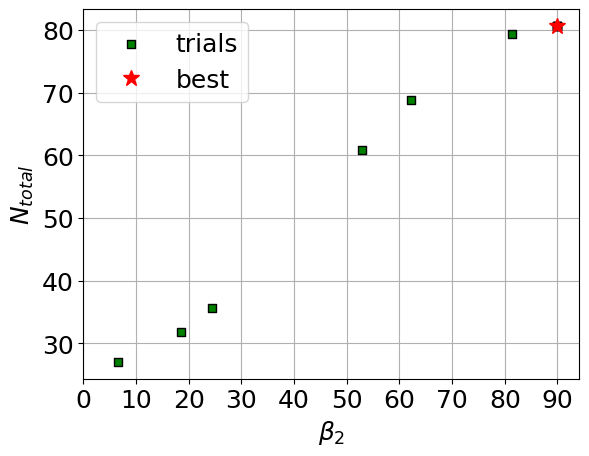

In [39]:
plt.figure()
plt.scatter(betas, N_totals, color='green', edgecolor='black', marker='s',
            zorder=2, label='trials')
plt.plot(beta_best, N_total_best, "*", color='red', ms=12, label='best')
plt.grid()
plt.xticks([10*i for i in range(10)])
plt.xlabel("$\\beta_2$")
plt.ylabel("$N_{total}$")
plt.legend()
plt.show()

As we see, the optimization found the same optimum.